<a href="https://colab.research.google.com/github/Dushxn/Deep-Learning-Project/blob/Shaini-Dev/Dl_PlantVillageMobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, pathlib, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# **Importing Plantvillage Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your zip file in Drive
zip_path = "/content/drive/MyDrive/DataSet/plantvillage.zip"

# Unzip into /content (fastest for Colab)
!unzip -q "$zip_path" -d /content/

# Check extracted folder name (sometimes it's "PlantVillage" or similar)
!ls /content

Mounted at /content/drive
 drive	'plantvillage dataset'	 sample_data


In [ ]:
import os, pathlib

DATA_DIR = "/content/plantvillage dataset"   # change if the extracted folder name differs
assert os.path.exists(DATA_DIR), "Check folder name after unzip!"
print("Dataset root:", DATA_DIR)

Dataset root: /content/plantvillage dataset


## **Dataset Analysis**

inspect folder structure and counts

In [ ]:
root = pathlib.Path(DATA_DIR)
# If dataset has 'train'/'test' folders or 'plant_village' etc, adapt this snippet.
# We'll assume images are organized in subfolders per class:
classes = [p.name for p in root.iterdir() if p.is_dir()]
classes = sorted(classes)
print(f"Found {len(classes)} classes.")
for c in classes[:30]:
    cnt = len(list(root.joinpath(c).glob('*')))
    print(f"{c}: {cnt} images")


Found 3 classes.
color: 38 images
grayscale: 38 images
segmented: 38 images


visualize class distribution (bar plot)

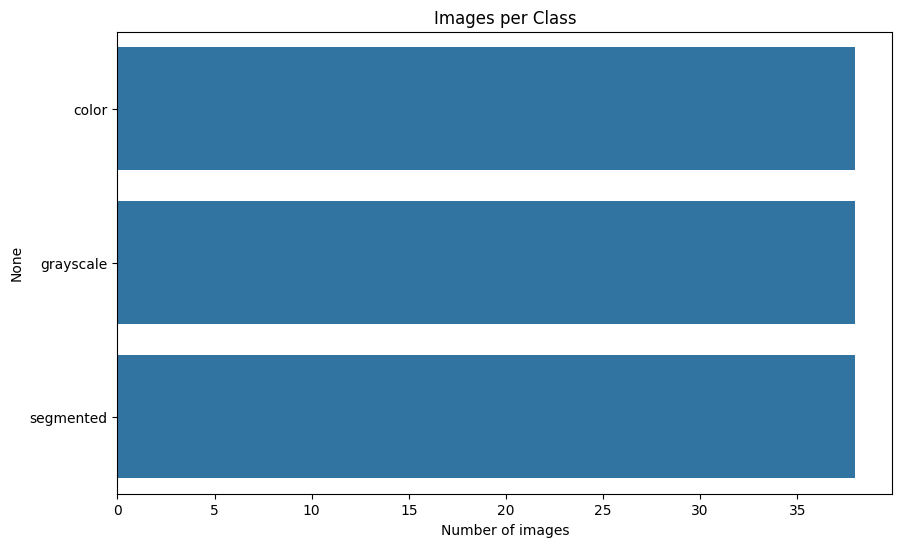

In [ ]:
counts = {}
for c in classes:
    counts[c] = len(list(root.joinpath(c).glob('*')))
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=counts_df['count'].values, y=counts_df.index)
plt.title("Images per Class")
plt.xlabel("Number of images")
plt.show()


show sample images per class

In [ ]:
import matplotlib.image as mpimg
def show_samples(classes, n_per_class=3, img_size=(224,224)):
    plt.figure(figsize=(n_per_class*3, len(classes)*3))
    i = 1
    for row, c in enumerate(classes):
        # Filter out directories and only include files
        imgs = [p for p in root.joinpath(c).glob('*') if p.is_file()][:n_per_class]
        for col, img_path in enumerate(imgs):
            ax = plt.subplot(len(classes), n_per_class, i)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            ax.set_title(c if col==0 else "")
            ax.axis('off')
            i += 1
    plt.tight_layout()
# show top 6 classes to avoid huge plot
show_samples(list(counts_df.index[:6]), n_per_class=4)

<Figure size 1200x900 with 0 Axes>

## **Data Preprocessing**

In [ ]:
# Define key parameters
IMG_SIZE = (124, 124) # A standard size for many CNNs
BATCH_SIZE = 16

# Create the training dataset (80% of the data)
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123, # Seed for reproducibility
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Create the validation dataset (20% of the data)
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Get the class names (they are inferred in alphabetical order by the function)
class_names = train_ds.class_names
print("Class names:", class_names)

Found 162916 files belonging to 3 classes.
Using 130333 files for training.
Found 162916 files belonging to 3 classes.
Using 32583 files for validation.
Class names: ['color', 'grayscale', 'segmented']


Configuring for Performance

In [ ]:
# This version streams from disk and uses much less RAM
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [ ]:
# Create a data augmentation layer
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

Train Models Below

🌿 8. Lightweight CNN: MobileNetV2 (Improved Version)

(a) Define Base Model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False
base_model.summary()


/tmp/ipython-input-3562358680.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 62, 62,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 62, 62,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 62, 62,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 62, 62,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 62, 62,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 62, 62,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 62, 62,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 62, 62,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 62, 62,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 62, 62,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 62, 62,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 63, 63,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 31, 31,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 31, 31,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 31, 31,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 31, 31,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

(b) Build Model Architecture

MobileNetV2 expects inputs scaled between -1 and 1, so we’ll include that preprocessing layer.

In [ ]:
inputs = keras.Input(shape=IMG_SHAPE)

# Apply augmentation
x = data_augmentation(inputs)

# Preprocess for MobileNet
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# Base model
x = base_model(x, training=False)

# Custom lightweight CNN layers (improvement)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Output layer
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,715 (9.87 MB)

 Trainable params: 329,219 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

(c) Compile the Model

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


(d) Train the Model

In [14]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 203s 24ms/step - accuracy: 0.9767 - loss: 0.0633 - val_accuracy: 0.9816 - val_loss: 0.0415
Epoch 2/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 198s 23ms/step - accuracy: 0.9758 - loss: 0.0646 - val_accuracy: 0.9819 - val_loss: 0.0399
Epoch 3/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 211s 25ms/step - accuracy: 0.9761 - loss: 0.0633 - val_accuracy: 0.9812 - val_loss: 0.0409
Epoch 4/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 210s 25ms/step - accuracy: 0.9769 - loss: 0.0597 - val_accuracy: 0.9823 - val_loss: 0.0400
Epoch 5/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 197s 23ms/step - accuracy: 0.9770 - loss: 0.0611 - val_accuracy: 0.9830 - val_loss: 0.0375
Epoch 6/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 205s 24ms/step - accuracy: 0.9774 - loss: 0.0608 - val_accuracy: 0.9812 - val_loss: 0.0401
Epoch 7/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 198s 23ms/step - accuracy: 0.9766 - loss: 0.0611 - val_accuracy: 0.9829 - val_loss: 0.0377
Epoch 8/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 195s 23ms/step - accuracy: 

(e) Fine-Tune (Unfreeze Last Few Layers)

In [15]:
base_model.trainable = True

# Only fine-tune last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 302s 35ms/step - accuracy: 0.9528 - loss: 0.1372 - val_accuracy: 0.9837 - val_loss: 0.0386
Epoch 2/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 299s 36ms/step - accuracy: 0.9733 - loss: 0.0693 - val_accuracy: 0.9837 - val_loss: 0.0354
Epoch 3/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 283s 34ms/step - accuracy: 0.9781 - loss: 0.0547 - val_accuracy: 0.9837 - val_loss: 0.0348
Epoch 4/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 337s 36ms/step - accuracy: 0.9806 - loss: 0.0444 - val_accuracy: 0.9840 - val_loss: 0.0336
Epoch 5/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 285s 34ms/step - accuracy: 0.9812 - loss: 0.0422 - val_accuracy: 0.9844 - val_loss: 0.0327
Epoch 6/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 288s 34ms/step - accuracy: 0.9827 - loss: 0.0377 - val_accuracy: 0.9841 - val_loss: 0.0335
Epoch 7/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 298s 36ms/step - accuracy: 0.9836 - loss: 0.0353 - val_accuracy: 0.9841 - val_loss: 0.0318
Epoch 8/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 314s 35ms/step - accuracy: 

(f) Evaluate Model

In [16]:
loss, acc = model.evaluate(val_ds)
print(f"✅ Validation Accuracy: {acc*100:.2f}%")


2037/2037 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.9855 - loss: 0.0297
✅ Validation Accuracy: 98.51%


(g) Visualize Accuracy & Loss

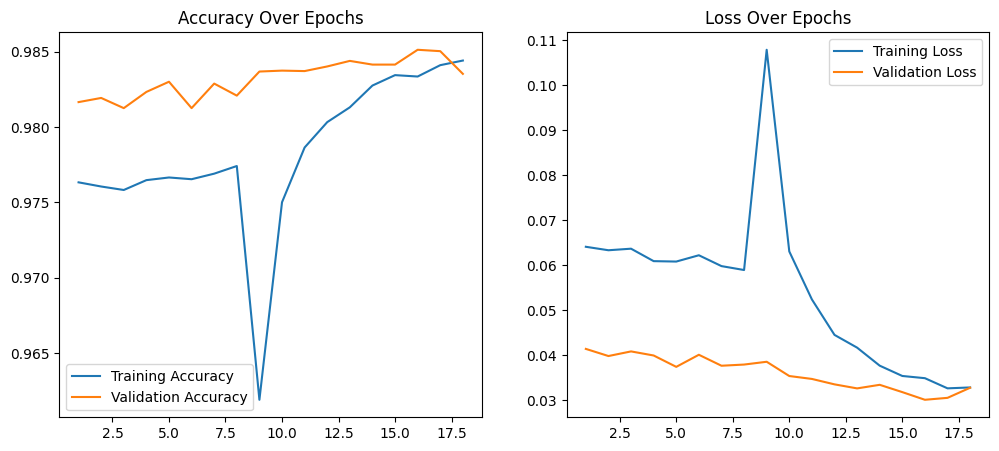

In [17]:
acc_all = history.history['accuracy'] + history_fine.history['accuracy']
val_acc_all = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss_all = history.history['loss'] + history_fine.history['loss']
val_loss_all = history.history['val_loss'] + history_fine.history['val_loss']

epochs = range(1, len(acc_all)+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc_all, label='Training Accuracy')
plt.plot(epochs, val_acc_all, label='Validation Accuracy')
plt.legend(); plt.title("Accuracy Over Epochs")

plt.subplot(1,2,2)
plt.plot(epochs, loss_all, label='Training Loss')
plt.plot(epochs, val_loss_all, label='Validation Loss')
plt.legend(); plt.title("Loss Over Epochs")
plt.show()


(h) Classification Report & Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

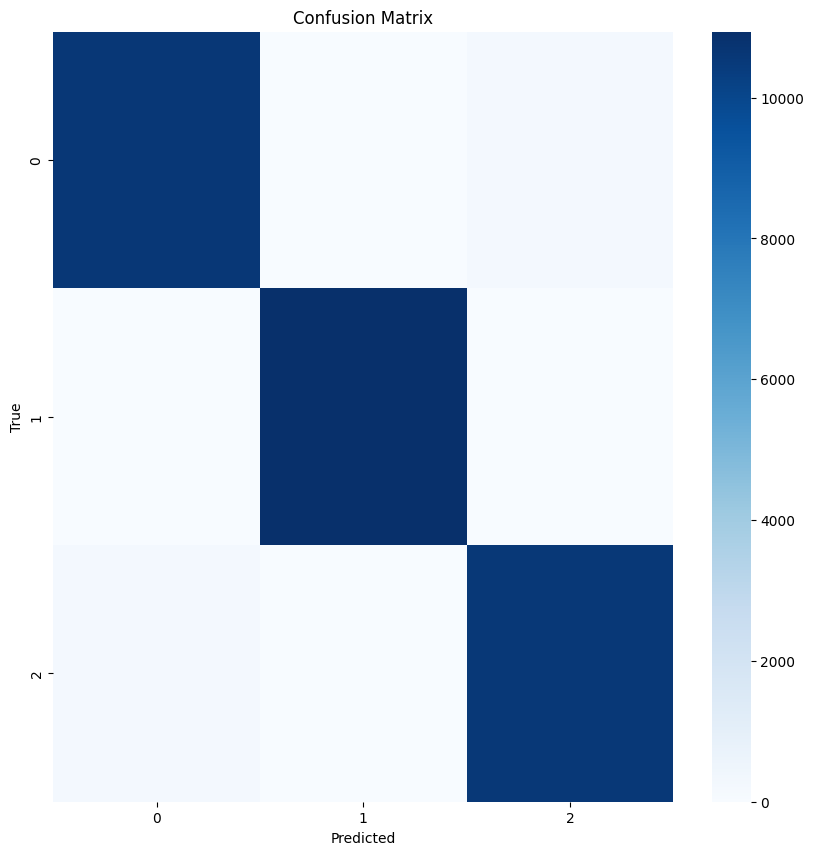

In [18]:
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


(i) Save the Model

In [19]:
model.save("mobilenet_plant_disease_model.h5")
print("✅ Model saved successfully!")
#model.save("mobilenet_plant_disease_model.keras")= modern

✅ Model saved successfully!


🌿 Step 11 — Optional: View Model Parameters

In [21]:
trainable_count = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_count = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])

print(f"Trainable params: {trainable_count:,}")
print(f"Non-trainable params: {non_trainable_count:,}")



Trainable params: 1,855,619
Non-trainable params: 732,096
